## Contemporary Music Recommendation System using Historical Preferences

### Overview

Many of us who are at the age when AARP cards arrive in the mail are still listening to the music of our highschool and college days. Exposure to new music has diminished due to the decreased use of the radio as part of our daily routines.  Spotify, iTunes, Pandora, and other music apps provide a plethora of music options, and they make recommendations for other music based on a playlist, but most often those recommendations are of the same time period and genre.  


#### Problem
Many of us would like to try new music, but don’t know where to start, and don’t have the patience or time to research or listen to new music as a hit or miss exercise.

#### Solution
My objective is to develop a recommendation system to highlight new songs and artists for listeners based on their  historical music preferences.



### Project Setup

#### Import Tools
This project includes obtaining the album and track audio features of songs from the 80s and 90s. These songs were found by identifying Spotify playlists representing music of different genres from this timeframe.  

In order to import, process, and build a model using these data, I am importing the following tools, including those required for clustering and measuring the accuracy of recommendations: KMeans, PCA, Silhouette Score, and Cosine Distance 

In [8]:
import pandas as pd
import numpy as np
import io, sys, os, re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import requests
from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import pdist

#### Establish connection to Spotify's API

In [9]:
import http.client

con = http.client.HTTPConnection('https://api.spotify.com', 80, timeout=100)

print(con)

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


In [11]:
# The following code passes credentials in order to access the Spotify API.  Credentials are stored 
# securely in a local file

with open("API.txt", encoding="utf-8-sig") as f:
    secret_ls = f.readlines()
    cid = secret_ls[0][:-1]
    secret = secret_ls[1]
        

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#### Create Datasets 

 - **track_data** - A list is created (track_data) to store all of the album and audio features of each track in the .txt file
 - **data** - the data from track_data is appended to another list (data).  This allows for additional data to be appended to the file if more tracks are found for training the model without having to import the entire list which is time consuming  
 
***NOTE*** - If adding data, do not initialize the data list.  Comment this line out to keep existing data in tact

##### Lists of dictionaries

In [12]:
# Initialize datasets (lists)

track_data = []
data = []

In [13]:
with open("URL.txt") as g:
    for url in g:
        playlist_link = url
        playlist_URI = playlist_link.split("/")[-1].split("?")[0]
        
        for track in sp.playlist_tracks(playlist_URI)["items"]:
            #URI
            track_uri = track["track"]["uri"]
    
            #Track name
            track_name = track["track"]["name"]
    
            #Main Artist
            artist_uri = track["track"]["artists"][0]["uri"]
            artist_info = sp.artist(artist_uri)
    
            #Name, popularity, genre (the first 6 genres in alphabetical order)
            artist_name = track["track"]["artists"][0]["name"]
            artist_pop = artist_info["popularity"]
            artist_genre_1 = artist_info["genres"][0:1]
            artist_genre_2 = artist_info["genres"][1:2]
            artist_genre_3 = artist_info["genres"][2:3]
            artist_genre_4 = artist_info["genres"][3:4]
            artist_genre_5 = artist_info["genres"][4:5]
            artist_genre_6 = artist_info["genres"][5:6]
    
            #Album
            album = track["track"]["album"]["name"]
            album_date = track["track"]["album"]["release_date"]
    
            #Popularity of the track
            track_pop = track["track"]["popularity"]
    
            #Track features
            danceability = sp.audio_features(track_uri)[0]['danceability']
            acousticness = sp.audio_features(track_uri)[0]['acousticness']
            energy = sp.audio_features(track_uri)[0]['energy']
            instrumentalness = sp.audio_features(track_uri)[0]['instrumentalness']
            key = sp.audio_features(track_uri)[0]['key']
            liveness = sp.audio_features(track_uri)[0]['liveness']
            loudness = sp.audio_features(track_uri)[0]['loudness']
            mode = sp.audio_features(track_uri)[0]['mode']
            speechiness = sp.audio_features(track_uri)[0]['speechiness']
            tempo = sp.audio_features(track_uri)[0]['tempo']
            valence = sp.audio_features(track_uri)[0]['valence']
    
            #List of Dictionary and audio feature items
            track_data = [
                track_uri, 
                track_name, 
                artist_name, 
                artist_pop, 
                artist_genre_1, 
                artist_genre_2, 
                artist_genre_3,
                artist_genre_4, 
                artist_genre_5, 
                artist_genre_6, 
                album, 
                album_date, 
                danceability, 
                acousticness, 
                energy, 
                instrumentalness, 
                key, 
                liveness, 
                loudness, 
                mode, 
                speechiness, 
                tempo, 
                valence]
    
            #Append track_data to data list
            data.append(track_data)

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

In [14]:
len(data)

220

##### Dataframes

In [15]:
# Convert dictionary (data) into pandas dataframe (df)
df = pd.DataFrame.from_dict(data)

##### Size and Shape of Dataframes

In [16]:
display(df.shape)
display(df.info)


(220, 23)

<bound method DataFrame.info of                                        0                                 1   \
0    spotify:track:1qPbGZqppFwLwcBC1JQ6Vr                        Wonderwall   
1    spotify:track:31AOj9sFz2gM0O3hMARRBx                Losing My Religion   
2    spotify:track:57iDDD9N9tTWe75x6qhStw             Bitter Sweet Symphony   
3    spotify:track:1d6KS9GH06JAd19uiBy9IE            Ironic - 2015 Remaster   
4    spotify:track:5DiXcVovI0FcY2s0icWWUu                         Mr. Jones   
..                                    ...                               ...   
215  spotify:track:58XWGx7KNNkKneHdprcprX         Rock You Like A Hurricane   
216  spotify:track:4TIJ7zSBNejpoIPaWpWRKc                        Rebel Yell   
217  spotify:track:029NqmIySn1kOY305AAhxT                      Sledgehammer   
218  spotify:track:7gSQv1OHpkIoAdUiRLdmI6                 I Won't Back Down   
219  spotify:track:11IzgLRXV7Cgek3tEgGgjw  Under Pressure - Remastered 2011   

                   

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       220 non-null    object 
 1   1       220 non-null    object 
 2   2       220 non-null    object 
 3   3       220 non-null    int64  
 4   4       220 non-null    object 
 5   5       220 non-null    object 
 6   6       220 non-null    object 
 7   7       220 non-null    object 
 8   8       220 non-null    object 
 9   9       220 non-null    object 
 10  10      220 non-null    object 
 11  11      220 non-null    object 
 12  12      220 non-null    float64
 13  13      220 non-null    float64
 14  14      220 non-null    float64
 15  15      220 non-null    float64
 16  16      220 non-null    int64  
 17  17      220 non-null    float64
 18  18      220 non-null    float64
 19  19      220 non-null    int64  
 20  20      220 non-null    float64
 21  21      220 non-null    float64
 22  22

In [18]:
# Update column headers

df.columns = ['track_uri', 
        'track_name', 
        'artist_name', 
        'artist_pop', 
        'artist_genre_1', 
        'artist_genre_2', 
        'artist_genre_3',
        'artist_genre_4', 
        'artist_genre_5', 
        'artist_genre_6', 
        'album', 
        'album_date', 
        'danceability', 
        'acousticness', 
        'energy', 
        'instrumentalness', 
        'key', 
        'liveness', 
        'loudness', 
        'mode', 
        'speechiness', 
        'tempo', 
        'valence']

##### Remove duplicate tracks from dataframe

Audio tracks may be duplicated across playlists.  As a result, the code below will identify duplicate entries and subsequently drop them from the file

In [19]:
df.drop_duplicates(subset = ['track_uri'], inplace = True)

In [20]:
type(df)

pandas.core.frame.DataFrame

In [21]:
# Convert album date to a date format
df['album_date'] = pd.to_datetime(df['album_date'])

In [22]:
df['album_date']

0     1995-10-02
1     1991-03-12
2     1997-09-29
3     1995-01-01
4     1993-01-01
         ...    
215   1984-03-27
216   1983-11-01
217   1986-05-19
218   1989-01-01
219   1982-05-03
Name: album_date, Length: 199, dtype: datetime64[ns]

In [23]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,[beatlesque],[britpop],[madchester],[permanent wave],[rock],[],...,0.002360,0.854,0.000000,2,0.1330,-5.609,1,0.0366,174.584,0.456
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,[alternative rock],[athens indie],[permanent wave],[pop rock],[rock],[],...,0.179000,0.855,0.000001,9,0.0987,-5.051,0,0.0295,125.639,0.803
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,[alternative rock],[britpop],[permanent wave],[pop rock],[rock],[shoegaze],...,0.033500,0.917,0.000000,9,0.4060,-6.006,1,0.0479,171.176,0.518
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,[canadian pop],[canadian singer-songwriter],[pop rock],[singer-songwriter],[],[],...,0.218000,0.582,0.000000,11,0.1590,-8.305,1,0.0508,114.926,0.365
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,[alternative rock],[neo mellow],[pop rock],[rock],[],[],...,0.183000,0.817,0.000003,0,0.2850,-6.542,1,0.0363,141.621,0.726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,spotify:track:58XWGx7KNNkKneHdprcprX,Rock You Like A Hurricane,Scorpions,72,[album rock],[german hard rock],[german metal],[german rock],[hard rock],[metal],...,0.005430,0.617,0.000146,4,0.2840,-12.931,0,0.0458,125.697,0.718
216,spotify:track:4TIJ7zSBNejpoIPaWpWRKc,Rebel Yell,Billy Idol,68,[album rock],[classic rock],[dance rock],[hard rock],[mellow gold],[new romantic],...,0.000753,0.864,0.000459,4,0.3540,-4.948,0,0.0610,166.312,0.484
217,spotify:track:029NqmIySn1kOY305AAhxT,Sledgehammer,Peter Gabriel,63,[album rock],[art rock],[classic rock],[mellow gold],[permanent wave],[rock],...,0.024600,0.685,0.000000,1,0.0370,-5.203,1,0.0334,96.458,0.424
218,spotify:track:7gSQv1OHpkIoAdUiRLdmI6,I Won't Back Down,Tom Petty,68,[album rock],[classic rock],[folk rock],[heartland rock],[mellow gold],[pop rock],...,0.050400,0.476,0.000003,7,0.1650,-13.487,1,0.0329,114.020,0.965


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 219
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         199 non-null    object        
 1   track_name        199 non-null    object        
 2   artist_name       199 non-null    object        
 3   artist_pop        199 non-null    int64         
 4   artist_genre_1    199 non-null    object        
 5   artist_genre_2    199 non-null    object        
 6   artist_genre_3    199 non-null    object        
 7   artist_genre_4    199 non-null    object        
 8   artist_genre_5    199 non-null    object        
 9   artist_genre_6    199 non-null    object        
 10  album             199 non-null    object        
 11  album_date        199 non-null    datetime64[ns]
 12  danceability      199 non-null    float64       
 13  acousticness      199 non-null    float64       
 14  energy            199 non-

In [161]:
import csv

df.to_csv('df.csv', index = True)

In [25]:
df.describe()

,artist_pop,danceability,acousticness,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,67.502513,0.599427,0.138020,0.725719,0.023371,5.165829,0.183140,-7.670864,0.758794,0.054076,120.997291,0.627556
std,9.099270,0.149831,0.166338,0.168941,0.089117,3.715602,0.154021,2.924230,0.428894,0.059709,25.280485,0.246657
min,34.000000,0.255000,0.000018,0.190000,0.000000,0.000000,0.031800,-18.064000,0.000000,0.023500,67.531000,0.038600
25%,61.000000,0.501000,0.013150,0.627500,0.000000,2.000000,0.084100,-9.329000,1.000000,0.033600,103.282500,0.455000
50%,68.000000,0.610000,0.078500,0.744000,0.000034,5.000000,0.117000,-7.195000,1.000000,0.037600,118.208000,0.659000
75%,75.000000,0.707000,0.199500,0.868000,0.002910,9.000000,0.265000,-5.350500,1.000000,0.049350,133.599000,0.824500
max,87.000000,0.920000,0.845000,0.989000,0.692000,11.000000,0.914000,-2.757000,1.000000,0.590000,206.680000,0.978000


array([[<AxesSubplot:title={'center':'artist_pop'}>,
        <AxesSubplot:title={'center':'album_date'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

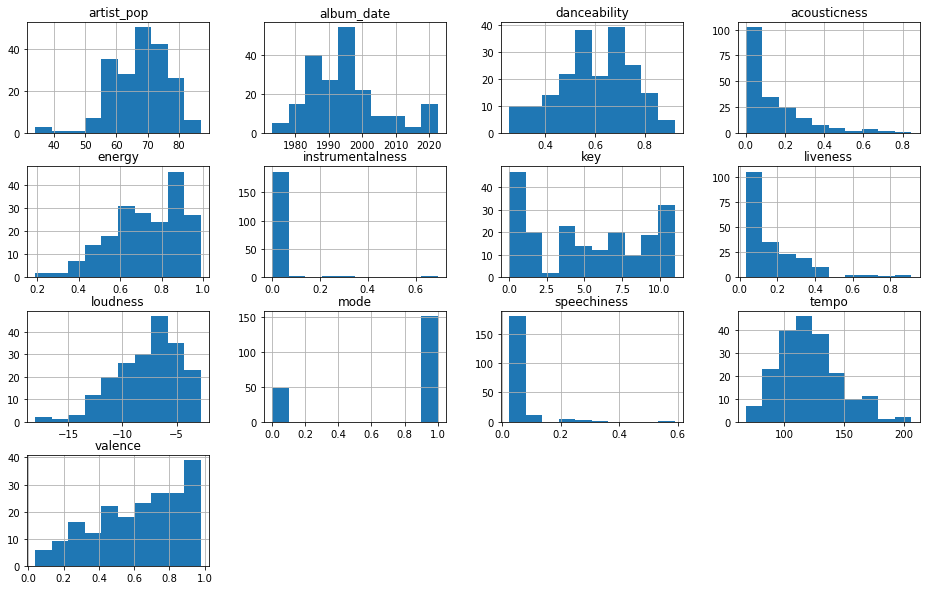

In [26]:
df.hist(figsize = (16,10))

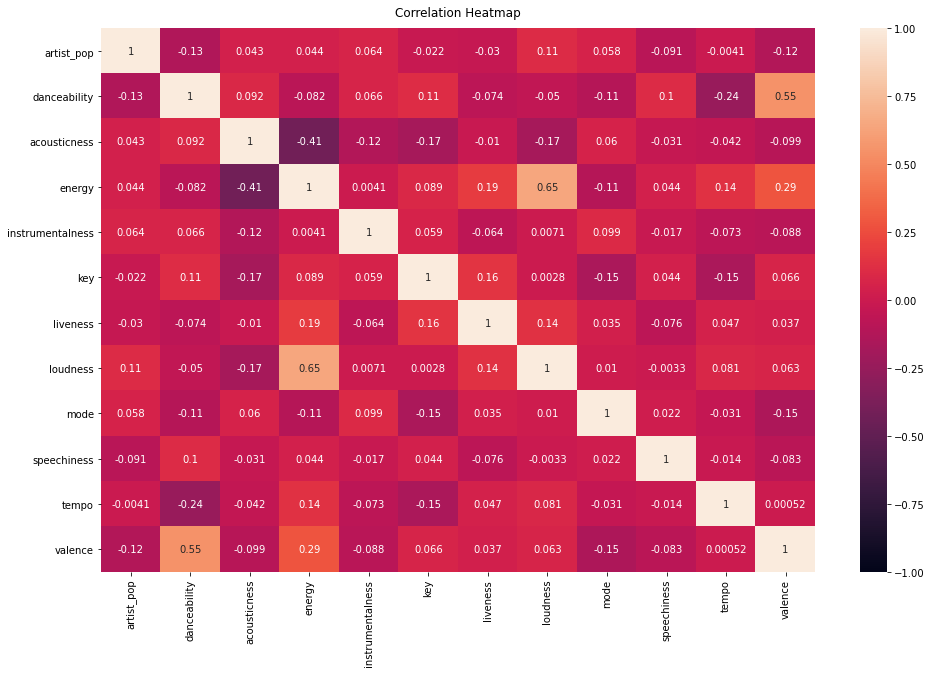

In [27]:
plt.figure(figsize = (16,10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


### Clustering

#### Create clusters using KMeans

In [28]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('kmeans', KMeans(n_clusters=4, n_init=10,
                             verbose=2))], verbose=True)

X = df.select_dtypes(np.number)
number_cols = list(X.columns)
cluster_pipeline.fit(X)

cluster_labels = cluster_pipeline.predict(X)
df['cluster_label'] = cluster_labels


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Initialization complete
Iteration 0, inertia 2606.439851018761
Iteration 1, inertia 1906.5785714060867
Iteration 2, inertia 1846.0167064238033
Iteration 3, inertia 1824.6972261799622
Iteration 4, inertia 1815.1004651099036
Iteration 5, inertia 1812.3834837331985
Iteration 6, inertia 1811.8700451433676
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 2214.910483495227
Iteration 1, inertia 1872.2914316456229
Iteration 2, inertia 1854.786123517719
Iteration 3, inertia 1842.6611054938326
Iteration 4, inertia 1838.6999436894805
Iteration 5, inertia 1837.19990097102
Iteration 6, inertia 1834.2333171859402
Iteration 7, inertia 1833.2568770314704
Iteration 8, inertia 1831.8964448421366
Iteration 9, inertia 1829.918449345963
Iteration 10, inertia 1828.6118343036467
Iteration 11, inertia 1827.8068966298624
Converged at iteration 11: strict convergence.
Initialization complete
Iteratio

Create Clusters by Track using KMeans

In [29]:
# setting verbose = 2 to display and plot inertia values

X = df.select_dtypes(np.number)

scaler = StandardScaler()
scaler.fit(X)
kmeans = KMeans(n_clusters=4, verbose=2, n_init=10) #<-- init=1, verbose=2
kmeans.fit(X)
print(scaler.mean_)


cluster_label = kmeans.predict(X)
df[cluster_label] = cluster_label



Initialization complete
Iteration 0, inertia 61377.961720006475
Iteration 1, inertia 40188.407199630594
Iteration 2, inertia 38860.31895612051
Iteration 3, inertia 38375.28028023522
Iteration 4, inertia 37660.80112700193
Iteration 5, inertia 36572.728557395734
Iteration 6, inertia 35940.18500223092
Iteration 7, inertia 35396.44438425211
Iteration 8, inertia 35036.91221922963
Iteration 9, inertia 34769.09350592935
Iteration 10, inertia 34520.56996734724
Iteration 11, inertia 34365.5474591508
Iteration 12, inertia 34297.72486737781
Iteration 13, inertia 34248.74041353925
Iteration 14, inertia 34114.40366725077
Iteration 15, inertia 34025.00808717468
Iteration 16, inertia 34017.97772016642
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 57820.49386835522
Iteration 1, inertia 39657.508659696636
Iteration 2, inertia 36412.3076314659
Iteration 3, inertia 35252.16613053434
Iteration 4, inertia 34400.91945375837
Iteration 5, inertia 34218.61609707191

In [30]:
df['cluster_label'].value_counts()

1    98
2    58
3    34
0     9
Name: cluster_label, dtype: int64

##### Plot inertia to identify optimal number of clusters

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

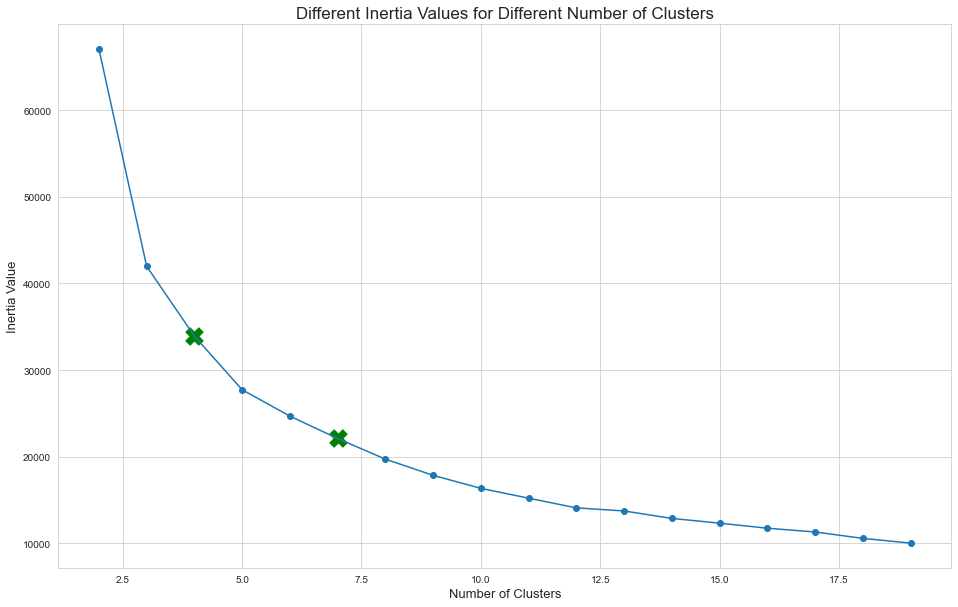

In [31]:
# Plotting Inertia

%matplotlib inline

## Reference plotting inertia article
plt.rcParams['figure.figsize'] = [16,10]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for n in range(2, 20):
    kmeans_model = KMeans(n_clusters=n)
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# plot the inertia curve
plt.plot(range(2,20),inertia_list)
plt.scatter(range(2,20),inertia_list)
plt.scatter(4, inertia_list[2], marker="X", s=300, c="g")
plt.scatter(7, inertia_list[5], marker="X", s=300, c="g")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia Value", size=13)
plt.title("Different Inertia Values for Different Number of Clusters", size=17)

In [32]:
number_cols

['artist_pop',
 'danceability',
 'acousticness',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

##### Visualizing the clusters

In [33]:
df

,track_uri,track_name,artist_name,artist_pop,artist_genre_1,artist_genre_2,artist_genre_3,artist_genre_4,artist_genre_5,artist_genre_6,...,loudness,mode,speechiness,tempo,valence,cluster_label,2,1,3,0
0,spotify:track:1qPbGZqppFwLwcBC1JQ6Vr,Wonderwall,Oasis,75,[beatlesque],[britpop],[madchester],[permanent wave],[rock],[],...,-5.609,1,0.0366,174.584,0.456,2,2,1,3,0
1,spotify:track:31AOj9sFz2gM0O3hMARRBx,Losing My Religion,R.E.M.,72,[alternative rock],[athens indie],[permanent wave],[pop rock],[rock],[],...,-5.051,0,0.0295,125.639,0.803,1,2,1,3,0
2,spotify:track:57iDDD9N9tTWe75x6qhStw,Bitter Sweet Symphony,The Verve,65,[alternative rock],[britpop],[permanent wave],[pop rock],[rock],[shoegaze],...,-6.006,1,0.0479,171.176,0.518,2,2,1,3,0
3,spotify:track:1d6KS9GH06JAd19uiBy9IE,Ironic - 2015 Remaster,Alanis Morissette,67,[canadian pop],[canadian singer-songwriter],[pop rock],[singer-songwriter],[],[],...,-8.305,1,0.0508,114.926,0.365,2,2,1,3,0
4,spotify:track:5DiXcVovI0FcY2s0icWWUu,Mr. Jones,Counting Crows,67,[alternative rock],[neo mellow],[pop rock],[rock],[],[],...,-6.542,1,0.0363,141.621,0.726,1,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,spotify:track:58XWGx7KNNkKneHdprcprX,Rock You Like A Hurricane,Scorpions,72,[album rock],[german hard rock],[german metal],[german rock],[hard rock],[metal],...,-12.931,0,0.0458,125.697,0.718,2,2,1,3,0
216,spotify:track:4TIJ7zSBNejpoIPaWpWRKc,Rebel Yell,Billy Idol,68,[album rock],[classic rock],[dance rock],[hard rock],[mellow gold],[new romantic],...,-4.948,0,0.0610,166.312,0.484,2,2,1,3,0
217,spotify:track:029NqmIySn1kOY305AAhxT,Sledgehammer,Peter Gabriel,63,[album rock],[art rock],[classic rock],[mellow gold],[permanent wave],[rock],...,-5.203,1,0.0334,96.458,0.424,2,2,1,3,0
218,spotify:track:7gSQv1OHpkIoAdUiRLdmI6,I Won't Back Down,Tom Petty,68,[album rock],[classic rock],[folk rock],[heartland rock],[mellow gold],[pop rock],...,-13.487,1,0.0329,114.020,0.965,3,2,1,3,0


In [330]:
#Getting unique labels
 
filter_label_1 = df[df['cluster_label'] == 0]

filter_label_1

plt.scatter(filter_label_1[:,0], filter_label_1[:,1])

#plt.show()

InvalidIndexError: (slice(None, None, None), 0)

In [34]:
df['cluster_label'].value_counts(normalize=True)


1    0.492462
2    0.291457
3    0.170854
0    0.045226
Name: cluster_label, dtype: float64

##### Calculate Silhouette Scores

For n_clusters = 2 The average silhouette_score is : 0.4557764644965329
For n_clusters = 3 The average silhouette_score is : 0.39457857446377753
For n_clusters = 4 The average silhouette_score is : 0.3181034420022085
For n_clusters = 5 The average silhouette_score is : 0.3295505393224224
For n_clusters = 6 The average silhouette_score is : 0.30358908383458166
For n_clusters = 7 The average silhouette_score is : 0.3072858730619291
For n_clusters = 8 The average silhouette_score is : 0.28953417912642354
For n_clusters = 9 The average silhouette_score is : 0.28682054069169377
For n_clusters = 10 The average silhouette_score is : 0.276386144213241
For n_clusters = 11 The average silhouette_score is : 0.2638746069520168
For n_clusters = 12 The average silhouette_score is : 0.2638874580712821
For n_clusters = 13 The average silhouette_score is : 0.24498473783086483
For n_clusters = 14 The average silhouette_score is : 0.24182602998509617
For n_clusters = 15 The average silhouette_score is : 

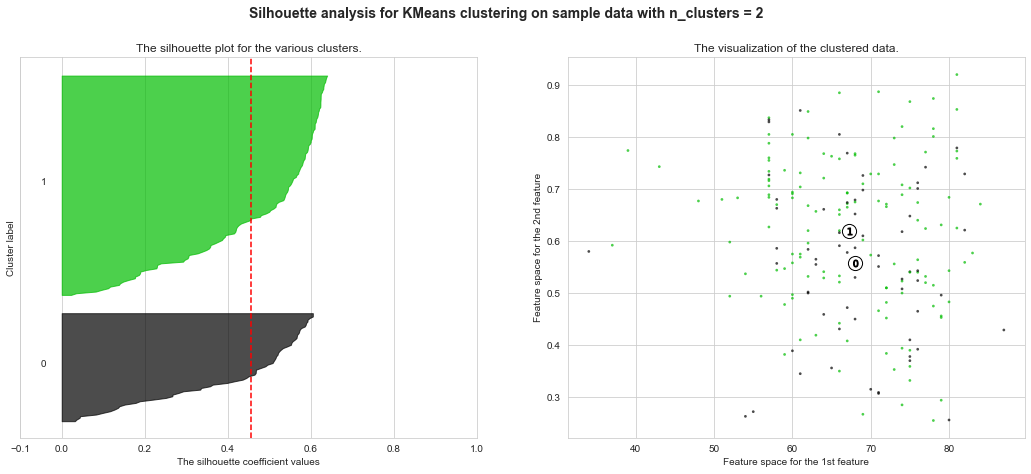

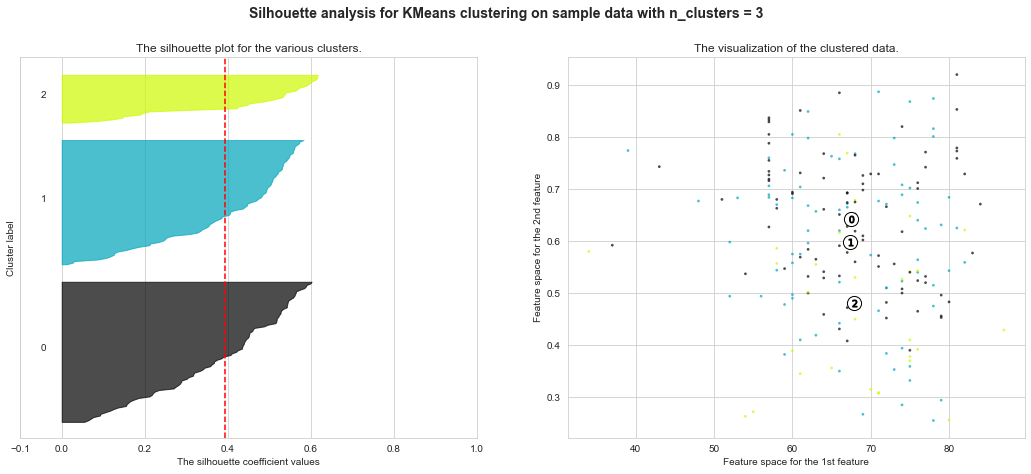

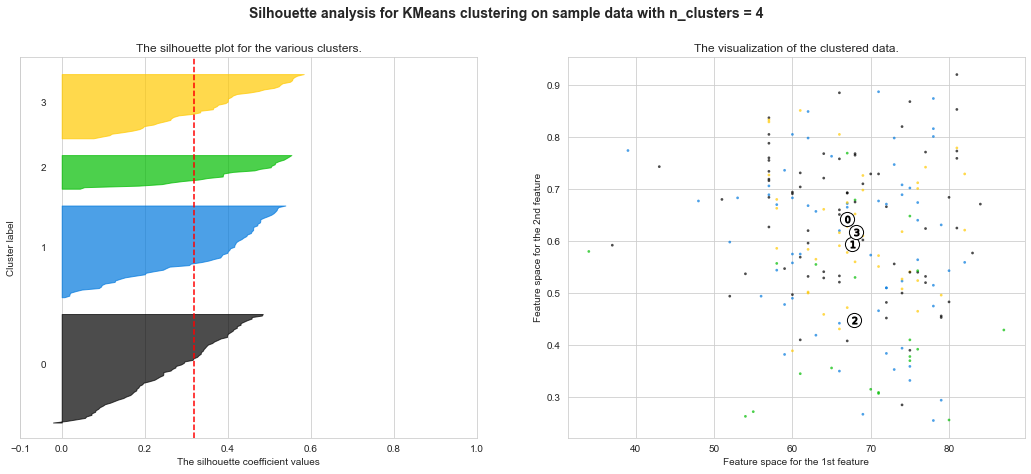

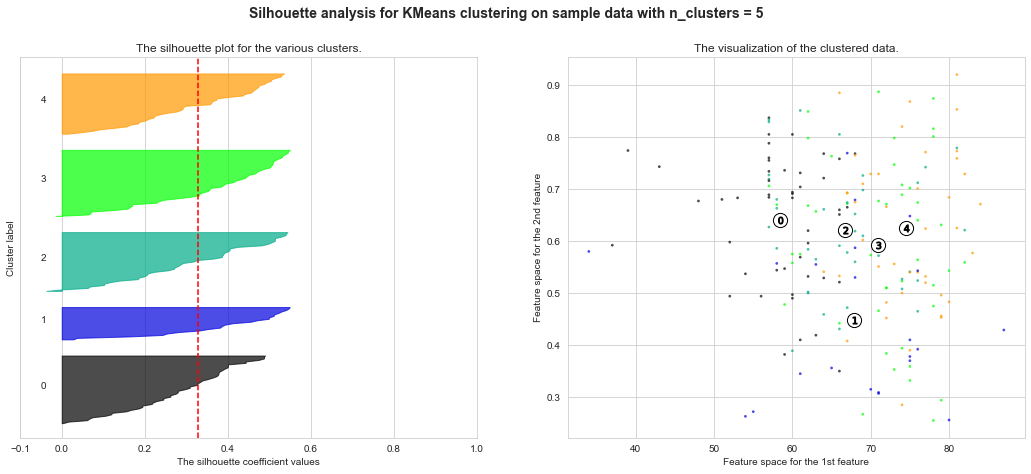

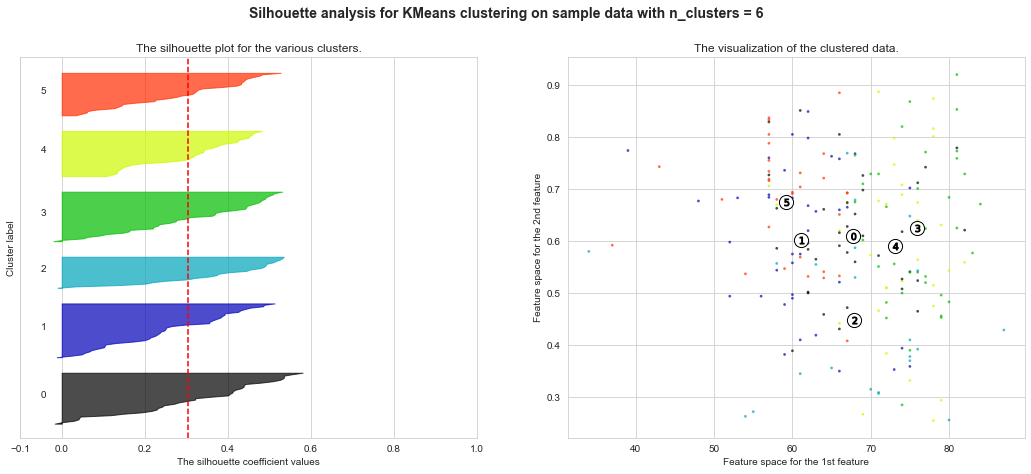

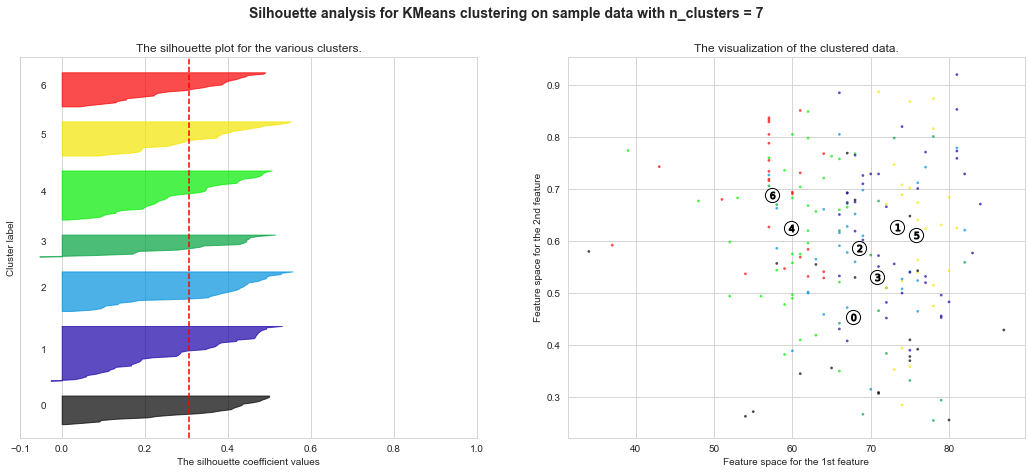

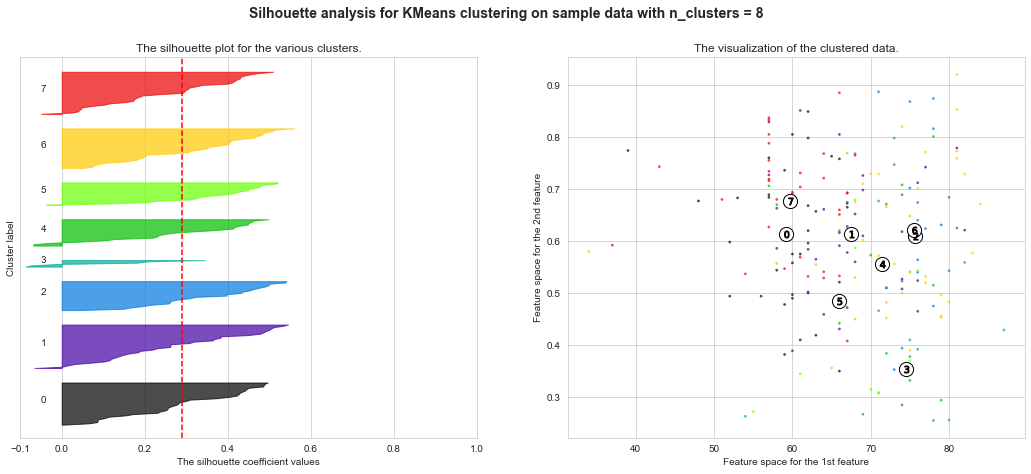

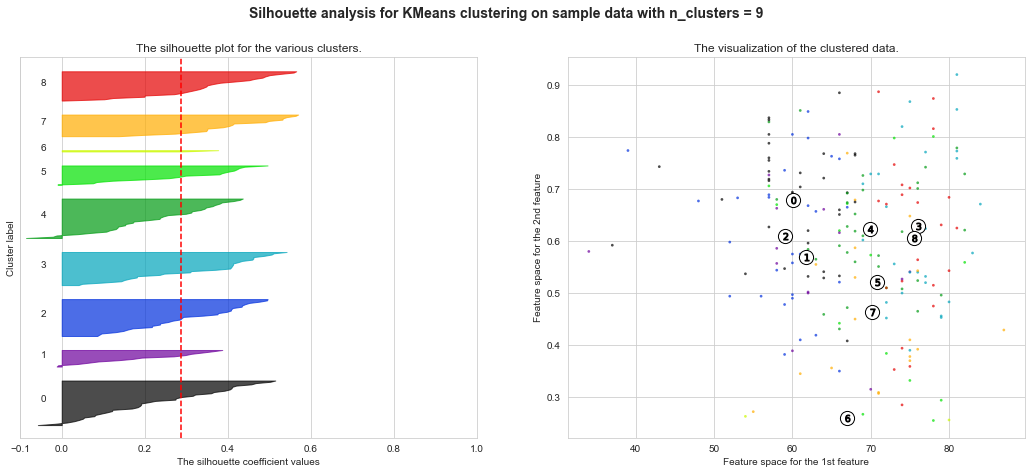

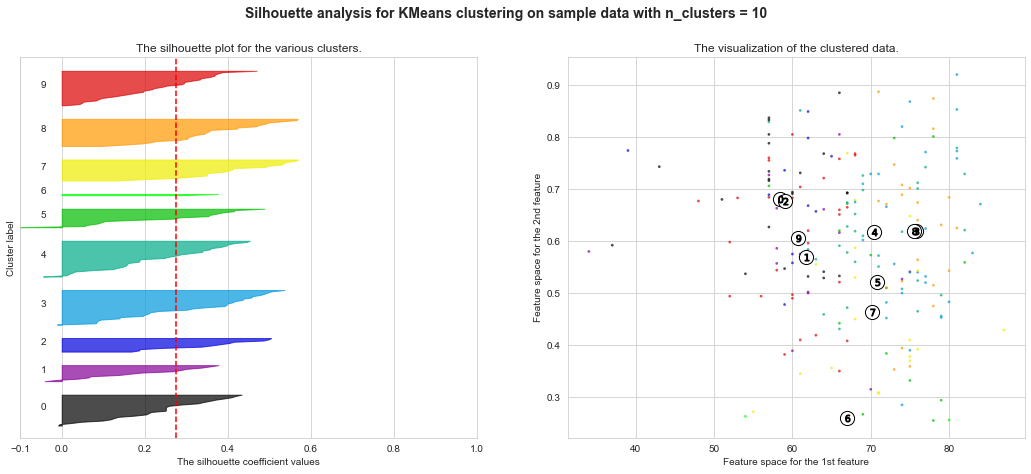

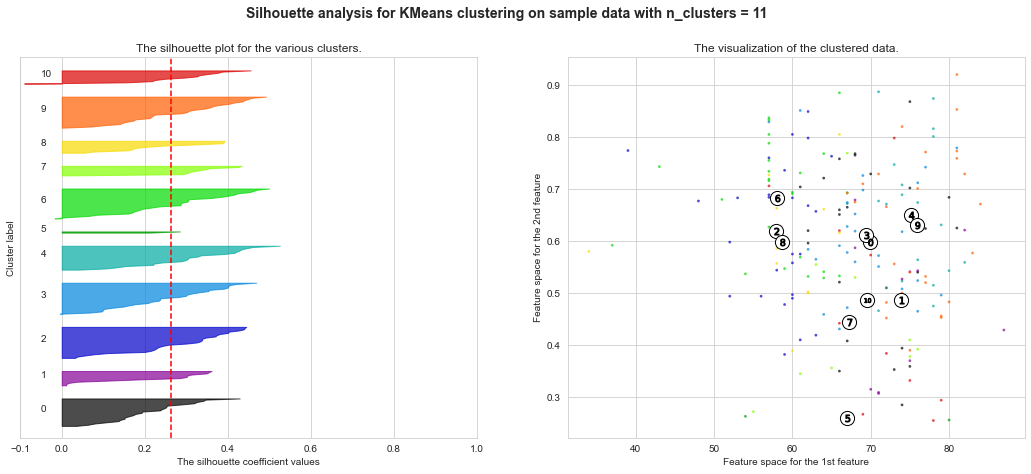

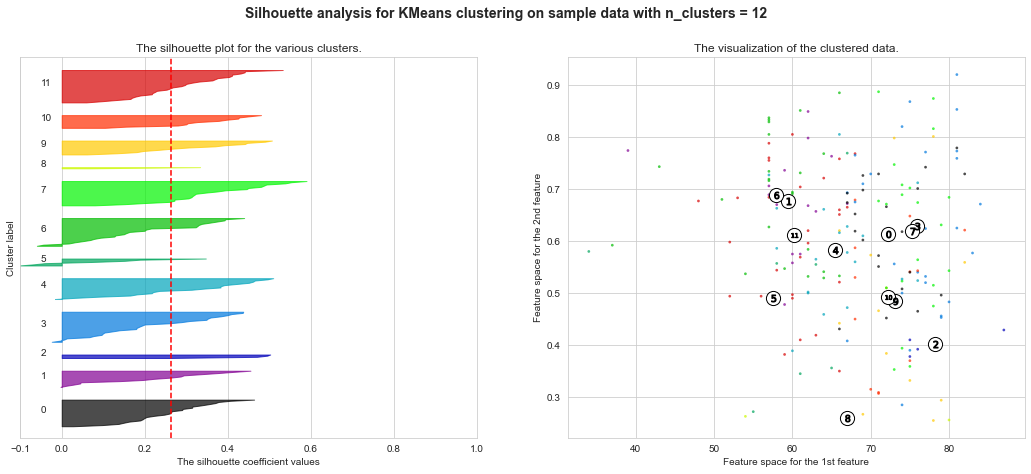

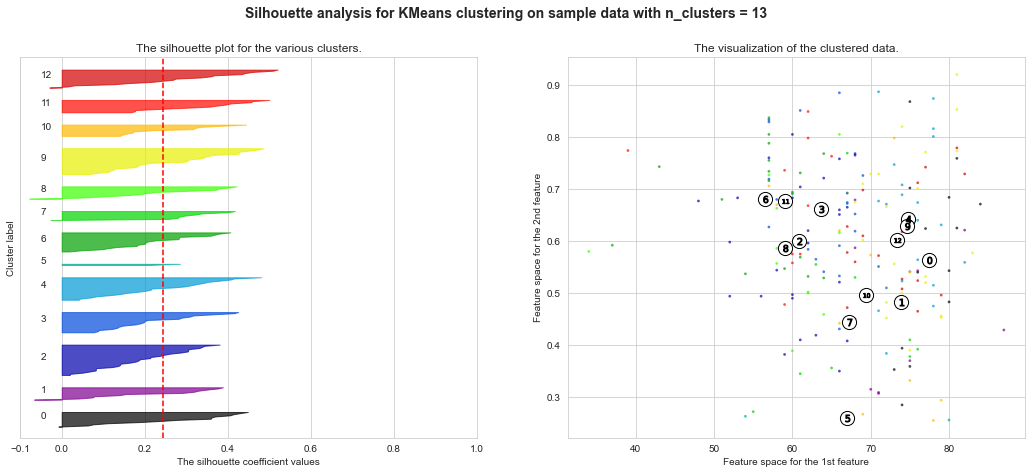

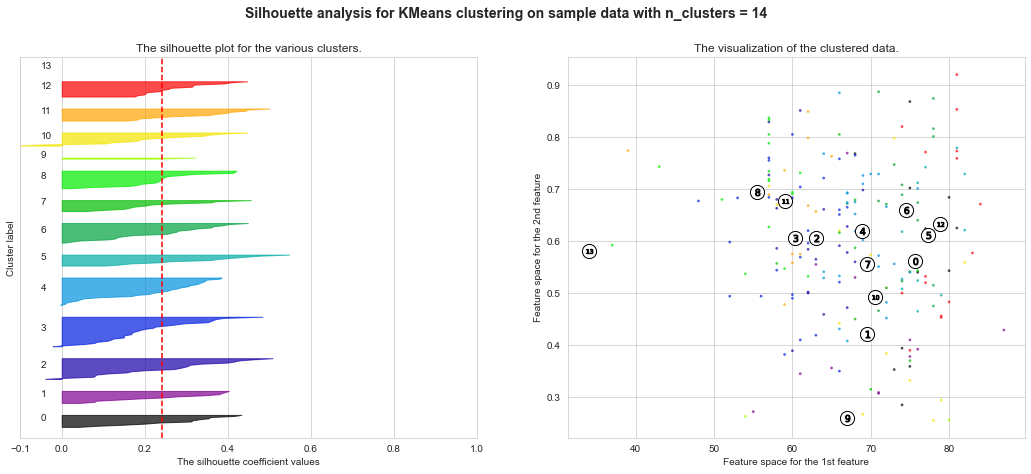

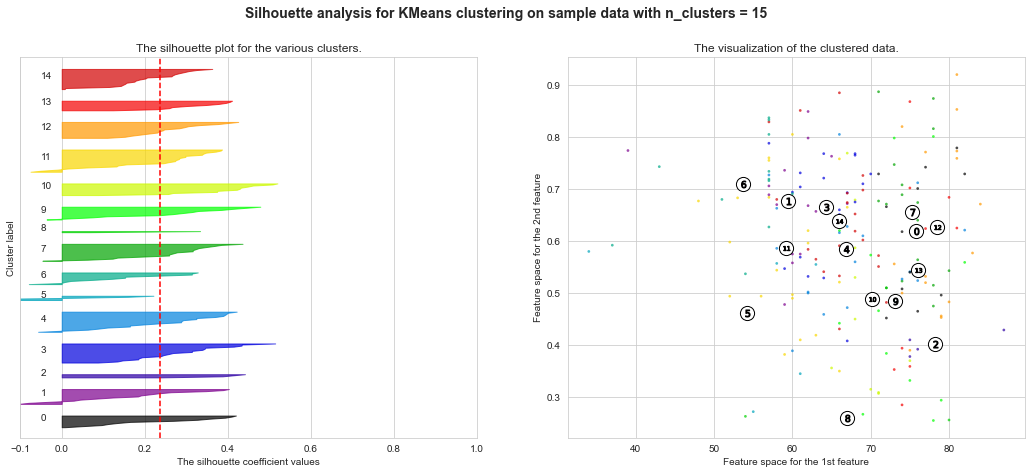

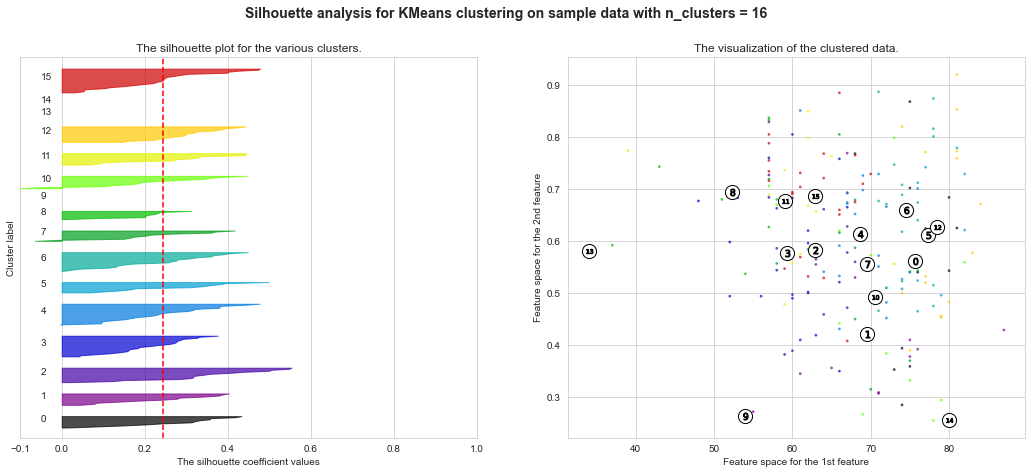

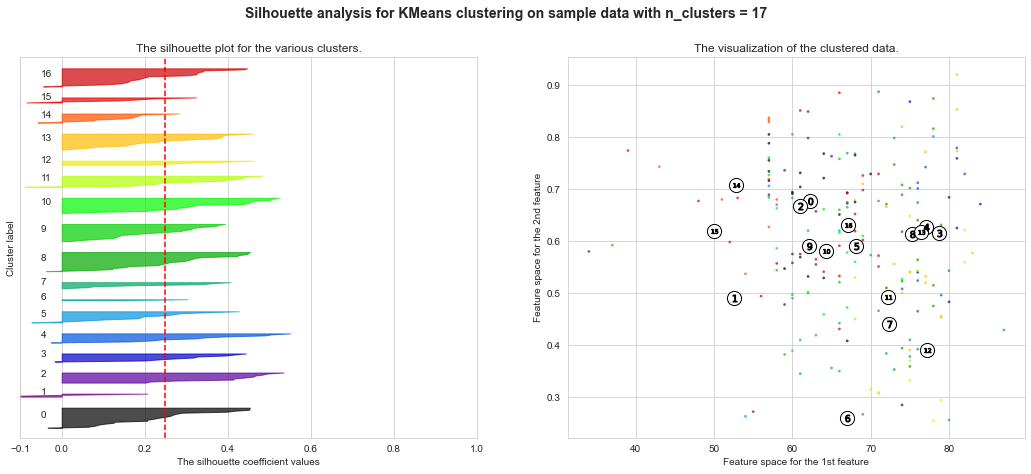

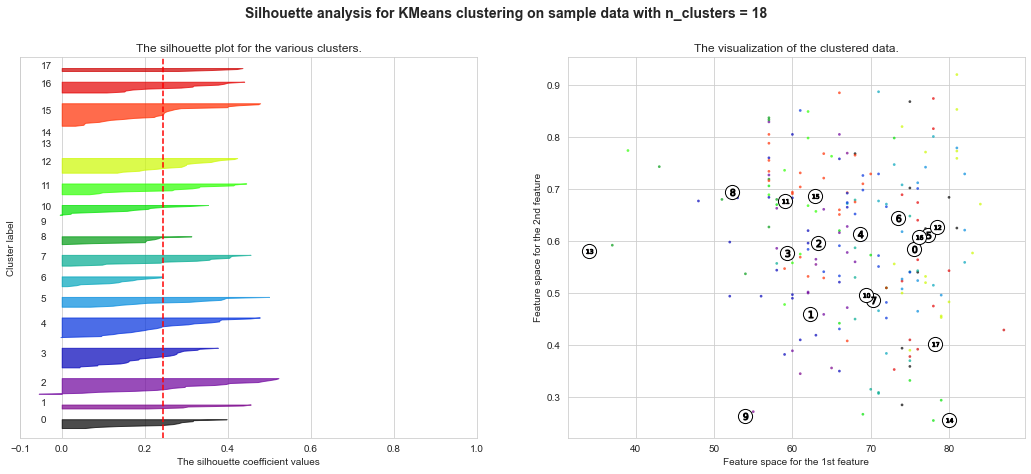

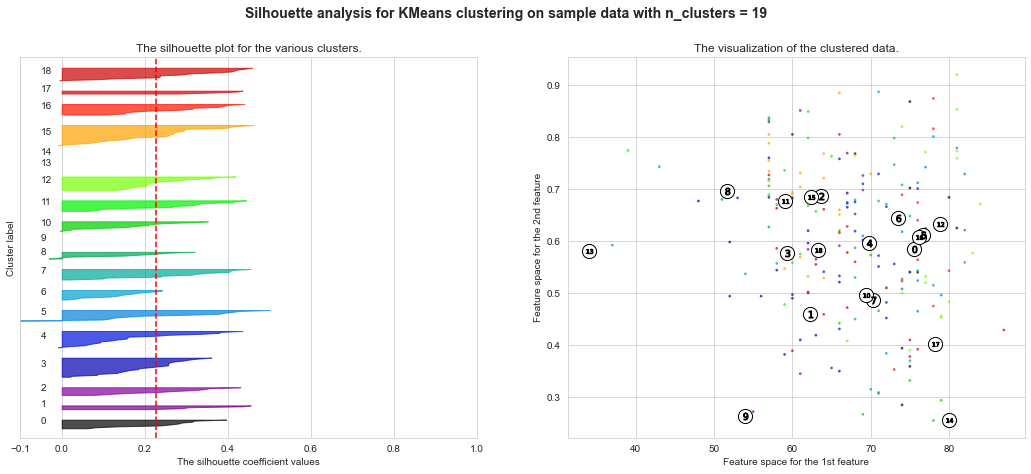

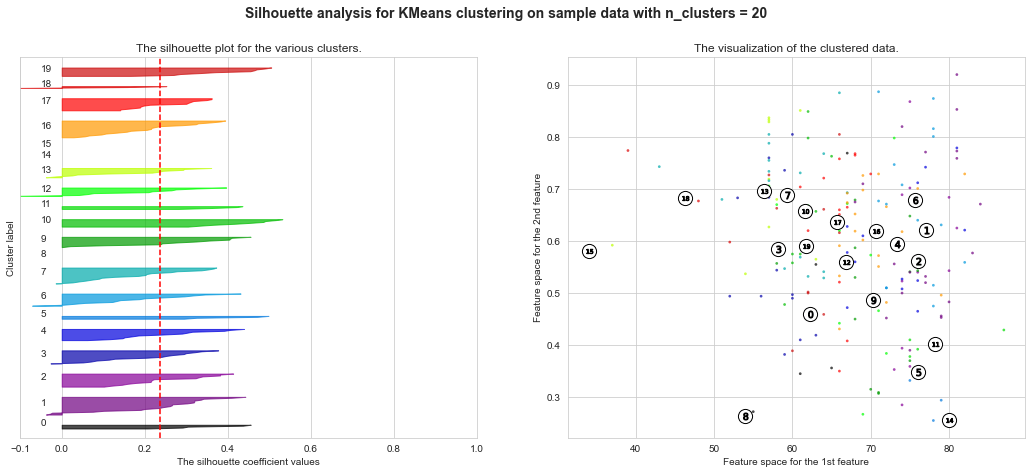

In [36]:
# Calculating and plotting Silhouette Score

%matplotlib inline

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Create K-Mode Clusters

In order to use both categorical and continuous variables to create clusters, I am using the K-Mode clustering algorithm

https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0

### Feature Selection

#### Run lasso regression using different alphas and display coefficients

In [75]:
X = df.drop('cluster_label')
y = df['cluster_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = Lasso(alpha=0.5, normalize=True)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

coef = pd.Series(lr.coef_, index = X.columns)

KeyError: "['cluster_label'] not found in axis"

##### Calculate MSE and R2 using Lasso

Generating song recommendations using cdist and cosine

In [421]:
from collections import defaultdict
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'acousticness', 'danceability', 'energy','instrumentalness', 
'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'artist_pop']

In [422]:
number_cols

['valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'artist_pop']

In [419]:


def get_track_data(track, df):
    

# Gets the song data for a specific song. The song argument takes the form of a dictionary with 
# key-value pairs for the name and release year of the song.
    
    try:
        song_data = df[(df['track_name'] == track['track_name']) 
                                & (df['album_date'] == song['album_date'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(track['track_name'], song['album_date'])
        

def get_mean_vector(song, df):
    
# gets the mean vector for a list of songs
    
    song_vectors = []
    
    for song in df:
        song_data = get_song_data(song, df)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(track['album_name']))
            continue
        song_vector = song_data[number_cols].values()
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
   
    """
    Utility function for flattening a list of dictionaries.
    """
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict
        

def recommend_songs(song_list, df, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, df)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(df[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [420]:
song_data

NameError: name 'song_data' is not defined